## Distance from Radar
When comparing lightning and radar data, the distance from the radar (range) is of interest. In this notebook we calculate mean annual flash density for different cities as a funtion of range. Since we also want to compare to the rain gage network, we will limit ourselves to flashes that occur between the radar and the gage network and beyond. 

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from pointprocess.region import Region

import matplotlib.pyplot as plt
from geopy.distance import vincenty, great_circle

# this is where my data path and colormap are set
from lightning_setup import *

In [2]:
def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    
    https://gist.github.com/jeromer/2005586
    """
    import math
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

We might not want this in the end, but for now, we will limit the lightning that we look at to those that occur along the same cone as the rain gages.

In [47]:
%%time
bearing = [calculate_initial_compass_bearing(c.CENTER, (lat, lon)) for 
           lat, lon in lat_lon[['lat','lon']].values]

min_bearing = min(bearing)
max_bearing = max(bearing)
print(min_bearing, max_bearing)

282.19302726734827 342.92044879102923
CPU times: user 863 µs, sys: 0 ns, total: 863 µs
Wall time: 773 µs


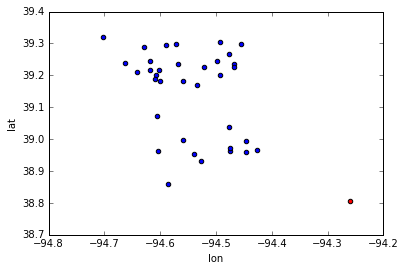

In [48]:
lat_lon.plot.scatter('lon', 'lat')
plt.scatter(c.CENTER[1], c.CENTER[0], c='r')

First we will calculate the distance in km from the radar to each lightning strike. Since this takes a while, we can store the output in HDF5 tables. 

In [49]:
import xarray as xr

In [50]:
%%time
for m in range(4,10):
    dist = []
    ds = xr.open_mfdataset(c.PATH+'{y}_{m:02d}_*.nc'.format(y='201*', m=m))
                                                            
    # this line needs to be changed to reflect the city
    if city == 'greer':
        ds0 = ds.where((ds.lon>c.CENTER[1]) & (ds.lat>c.CENTER[0]) & (ds.cloud_ground == b'G')).dropna('record')
    elif city == 'stlouis':
        ds0 = ds.where((ds.lon>c.CENTER[1]) & (ds.cloud_ground == b'G')).dropna('record')
    elif city == 'philly':
        ds0 = ds.where((ds.lon<c.CENTER[1]) & (ds.cloud_ground == b'G')).dropna('record')
    elif city == 'kansas':
        ds0 = ds.where((ds.lon<c.CENTER[1]) & (ds.lat>c.CENTER[0]) & (ds.cloud_ground == b'G')).dropna('record')
    else:
        ds0 = ds

    print(ds0.record.shape)
    locs = np.stack([ds0.lat.values, ds0.lon.values], axis=1)
    ds0.close()
    ds.close()
    for lat, lon in locs:
        bearing = calculate_initial_compass_bearing(c.CENTER, (lat, lon))
        if min_bearing < bearing < max_bearing:                                                    
            dist.append(vincenty(c.CENTER, (lat, lon)).kilometers)   
    computed = pd.HDFStore("computed")
    computed['dist_from_radar_2010_2015_{mm:02d}_{city}_city_area'.format(mm=m, city=city)] = pd.Series(dist)
    computed.close()
    print(m)

(196705,)
4
(350371,)
5
(762608,)
6
(477003,)
7
(470449,)
8
(325273,)
9
CPU times: user 3min 26s, sys: 11.1 s, total: 3min 37s
Wall time: 5min 40s


Then we will load in all the data from the HDF5 tables. That consists of the distance between every strike and the radar. So we can then bin and normalize. We count the number of strikes in each ring and then divide by the area of the ring. Since we have more like a slice of pizza, the area that we divide by is not equal to the area of the whole ring.

In [51]:
%%time
hist = {}
for m in range(4,10):
    computed = pd.HDFStore("computed")
    dist = computed['dist_from_radar_2010_2015_{mm:02d}_{city}_city_area'.format(mm=m, city=city)].values
    computed.close()
    FC, edges = np.histogram(dist, range(0, 220, 1))
    area = [np.pi*(edges[i+1]**2-edges[i]**2)*(max_bearing-min_bearing)/360. for i in range(len(FC))]
    hist.update({m: FC/area/25})
centers = (edges[1:]+edges[:-1])/2.
hist.update({'km_from_radar': centers})
df = pd.DataFrame.from_dict(hist).set_index('km_from_radar')
df.columns.name = 'mean_annual_flash_density'

CPU times: user 113 ms, sys: 15 ms, total: 128 ms
Wall time: 650 ms


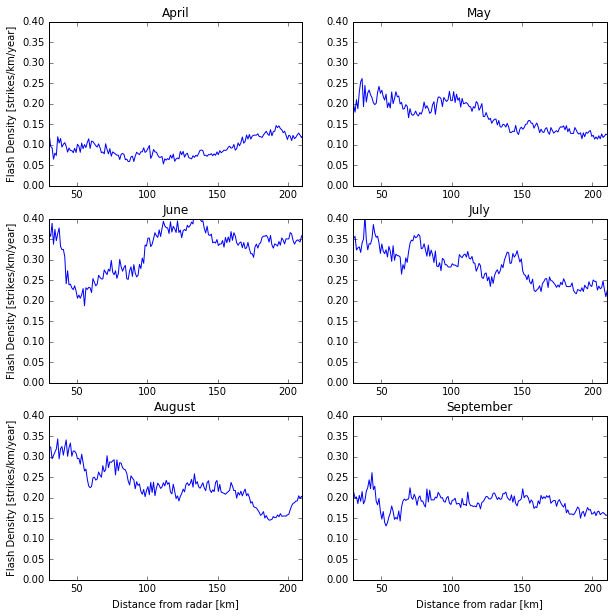

In [52]:
n=1
plt.figure(figsize=(10,10))
for m in range(4,10):
    ax = plt.subplot(3,2,n)
    ax.plot(centers, hist[m])
    if n%2 == 1:
        ax.set_ylabel("Flash Density [strikes/km/year]")
    if n>4:
        ax.set_xlabel("Distance from radar [km]")
    ax.set_xlim(30,210);
    ax.set_ylim(0,.4)
    ax.set_title(months[m])
    n+=1

In [53]:
df.to_csv("Kansas City monthly CG FD as a function of distance from radar.csv")